# Simulating Zodiacal Light 

Local and exo-Zodiacal light are important astrophysical noise sources that must be considered when estimating integration times.  ``EXOSIMS`` provides zodiacal light modeling via the `ZodiacalLight` module, which comes in various different implementations.  By default, we will typically use the `Stark` version of the `ZodiacalLight` module, which implements models based on the papers by Stark et al. (http://dx.doi.org/10.1088/0004-637X/795/2/122 and http://dx.doi.org/10.1088/0004-637X/808/2/149).  The full model used in `EXOSIMS` is described in detail here: https://exosims.readthedocs.io/en/latest/concepts.html#zodiacal-light


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway" 
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

### 🟠 Import jupyter widget for Colab

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [1]:
# import all required packages
from corgietc.corgietc import corgietc
import os
import json
import EXOSIMS.Prototypes.TargetList
import EXOSIMS.Prototypes.TimeKeeping
import EXOSIMS.Observatory.ObservatoryL2Halo
import copy
import astropy.units as u
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt

## Modeling Local Zodi

As described in the 'Anatomy of an Integration Time Calculation' notebook, for integration time calculations we need the surface brightness of the local zodiacal light at the time of our observation.  The local zodi varies in brightness as a function of the geometry of the observation. That is, it is parametrized by the target ecliptic latitude and target solar ecliptic longitude at the time of observation:
![Local Zodiacal Light Spatial Distribution](https://exosims.readthedocs.io/en/latest/_images/zodi_intensity_leinert17.png)

The minimum local zodiacal light contribution typically occurs at around 135$^\circ$ solar longitude and for targets off of the ecliptic.

Let's load our default input specification, build a TargetList with a few targets, and then look at our options for evaluating Zodiacal light. We're going to use the HWO Mission Stars input star catalog (https://exoplanetarchive.ipac.caltech.edu/docs/MissionStellar.html), not because these represent particularly good targets for the Roman Coronagraph, but because it is a useful set of nearby, real targets.

In [2]:
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())
specs["modules"]["StarCatalog"] = "HWOMissionStars"
TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs))
ZL = TL.ZodiacalLight
OS = TL.OpticalSystem

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:379: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported HWOMissionStars (implementation) from EXOSIMS.StarCatalog.HWOMissionStars
Loaded data from /Users/ds264/.EXOSIMS/downloads/HWOStarList_20250305095256.pkl
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
164 targets imported from star catalog.
164 targets remain after removing those where spectral class cannot be established.
164 targets remain after removing white dwarfs and subdwarfs
164 targets remain after nan filtering.
164 targets remain after removing zero luminosity targets.

As we already saw in the 'Anatomy of an Integration Time Calculation' notebook, the `ZodiacalLight` object provides a default value for local zodi via its attribute `fZ0`, which is actually a conversion to flux of the magnitude (per square arcsecond) value encoded in attribute `magZ`, which can be set from the input specification and defaults to 23:

In [3]:
print(ZL.magZ, ZL.fZ0)

23.0 6.309573444801917e-10 1 / arcsec2


While this is an okay value to use for a quick calculation, it has a lot of limitations.  First: it does not reflect the known spatial variability in local zodi, meaning that you are assuming possibly idealized conditions.  More importantly, it does not reflect the wavelength dependence of the zodiacal light.  Fortunately, the same `ZodiacalLight` object provides methods for computing both of these.

### Local Zodi Intensity as a function of target location

Method `zodi_intensity_at_location` computes the zodiacal light specific intensity for a given target look vector as 500 nm.  Let's see if we can reproduce the spatial variability seen in the figure, above.

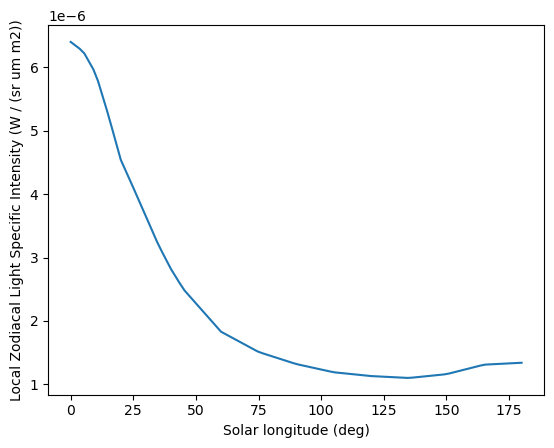

In [4]:
lon = np.linspace(0,180,100)*u.deg # range of solar longitude 
lat = np.ones(len(lon))*30*u.deg # constant 30 degree latitude
Izod = ZL.zodi_intensity_at_location(lon, lat)
plt.figure()
plt.plot(lon, Izod)
plt.xlabel("Solar longitude (deg)")
plt.ylabel(f"Local Zodiacal Light Specific Intensity ({Izod.unit})");

We have successfully reproduced the spatial variation in the zodi with solar longitude, but note that, by default, this method will return values in units of W m-2 um-1 sr-1, meaning that a bit more work is needed to get this output into the units we ultimately want (effectively photons per square arcsecond, with the photons being implicit in our final unit definition).  Before we get to that, let's look at the wavelength variability of the zodiacal light.

### Local Zodi Intensity as a function of wavelength

Method `zodi_color_correction_factor` return a scaling value representing the ratio of the zodi at an arbitrary wavelength to it's intensity at 500 nm (the reference wavelength used everywhere else). Here's what this looks like:

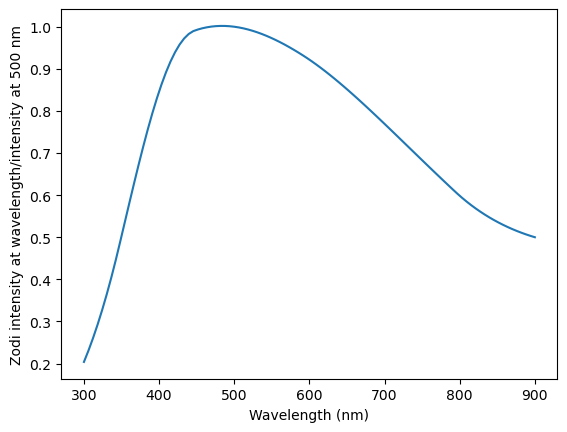

In [5]:
lams = np.linspace(300, 900, 100)*u.nm
fcolor = ZL.zodi_color_correction_factor(lams)
plt.figure()
plt.plot(lams, fcolor)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Zodi intensity at wavelength/intensity at 500 nm");

**Important**: Note that while this factor is unitless, its value will be different if scaling power units vs. photon units.  Both this method and the previous one take an optional keyword (`phot_units`) which default to False.  This keyword must have the same value when calling both methods if the color factor is going to be applied to the output of `zodi_intensity_at_location`.

### Putting things together

In order to properly model the local zodi value for a given observation, we need to use both of these methods together.  Fortunately, `ZodiacalLight` provides another method, `fZ` which does exactly that.  The only caveat is that use of this method requires instantiation of an `Observatory` object, which is used to track the location of the observatory in time (such that look vectors can be accurately computed).  We'll first instantiate this object, and then use it for a sample calculation. 

In [6]:
#NB: This is *not* the Roman orbit, but it is close enough for our purposes
Obs = EXOSIMS.Observatory.ObservatoryL2Halo.ObservatoryL2Halo()

    orbitdatapath is none
orbit_datapath (/Users/ds264/.EXOSIMS/cache/v3.6.4/L2_halo_orbit_six_month.p) either does not exist, or inputs do not include all relevant data fields.


The inputs to `ZodiacalLight.fZ` are:
1. The Observatory
2. The Target List
3. The indices of the targets of interest (just like `calc_intTime`)
4. The absolute times of observation(s) to model (in MJD)
5. The observing mode

Let's select our favorite target (47 UMa) and see how the zodi contribution varies over the course of one year.

In [7]:
# generate starting time and array of observation times
t_str = ["2027-01-01T00:00:00.0"]
t0 = Time(t_str, format="isot", scale="tai")
t0.format = "mjd"
ts = t0 + np.arange(365)*u.d
t0

<Time object: scale='tai' format='mjd' value=[61406.]>

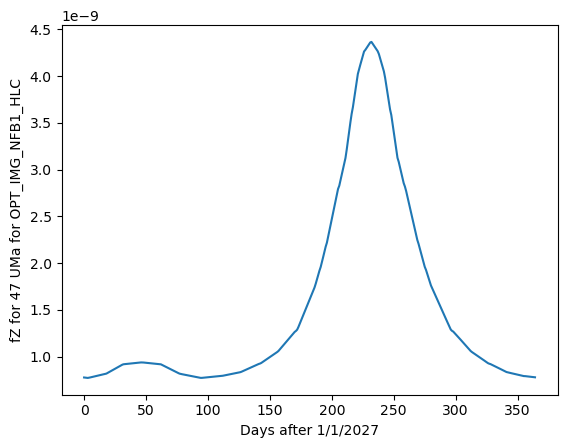

In [8]:
# identify 47 UMa c
sInd = np.where(TL.Name == "HIP 53721")[0]
# extract first observing mode from optical system
mode = OS.observingModes[0]
# compute zodi flux
fZ = ZL.fZ(Obs, TL, sInd, ts, mode)
plt.figure()
plt.plot(range(len(ts)), fZ)
plt.xlabel("Days after 1/1/2027")
plt.ylabel(f"fZ for 47 UMa for {mode['Scenario']}");

One thing we can immediately see is that even in the best case, the local zodi contribution for this target in this observing mode (with a central wavelength of 575 nm) will be slightly higher than the constant 23 magnitude assumption.

## Modeling Exo-Zodi

As we saw in the 'Anatomy of an Integration Time Calculation' notebook, for integration time calculations we need the intensity of the exo-zodiacal light.  Unlike the local zodiacal light, there is no particular utility in assuming any time variability (unless you know something we don't), so typically the exozodi will just be a constant value for a given target.  However, the exozodi will also have wavelength dependence, and it is typical to assume an inverse square relationship of exozodi contribution with planet orbital radius (see the Stark papers linked above for further details).

Fortunately, just by instantiating a `TargetList` object, a lot of heavy lifting has been done for us. For each of our targets and observing modes, the intensities of exozodi (assuming equivalent brightness to one local zodi) have been pre-computed for planets at 1 AU.  We can now scale these as we see fit to get our input values for integration time calculations.

The pre-computed values are stored in arrays (of equal length to the number of targets) in a dictionary called `JEZ0`.  The dictionary is keyed by each observing mode's unique identified (`mode["hex"]`). So, for a given observing mode and target index, we can pull out the appropriate value:

In [9]:
JEZ0 = TL.JEZ0[mode["hex"]][sInd]
JEZ0

<Quantity [9.53851952] ph / (s arcsec2 m2)>

This value represents the exozodiacal light contribution when observing a planet about 47 UMa located at 1 AU, assuming that 47 UMa has the exact same zodiacal dust cloud as the solar system.  If we wish to change the location of the planet, or the number of assumed exozodis, we just scale this value.  Here's what it looks like for a 5 AU planet and 10 zodis of exozodi:

In [10]:
JEZ0*10/(5**2)

<Quantity [3.81540781] ph / (s arcsec2 m2)>

The other important caveat is that these values all assume a particular system inclination.  We can see the specific one by querying our TargetList: 

In [11]:
TL.systemInclination[sInd]

<Quantity [90.] deg>

Because of settings in our default input specification, all of these `JEZ0` values are being computed assuming strictly edge-on systems.  However, we can modify this assumption by adding an inclination correction factor:

In [12]:
ZL.calc_fbeta([15,45,60,90]*u.deg)*JEZ0

<Quantity [3.89001075, 4.79590367, 5.86166004, 9.53851952] ph / (s arcsec2 m2)>

As we can see, the closer the system gets to face-on, the less the exozodiacal contribution. For more details on this, see here: https://exosims.readthedocs.io/en/latest/concepts.html#exozodiacal-light